Sliding window configuration (21 windows):
  Win  0: -11000 to  -9000 bp (original)
  Win  1: -10000 to  -8000 bp (overlap )
  Win  2:  -9000 to  -7000 bp (original)
  Win  3:  -8000 to  -6000 bp (overlap )
  Win  4:  -7000 to  -5000 bp (original)
  Win  5:  -6000 to  -4000 bp (overlap )
  Win  6:  -5000 to  -3000 bp (original)
  Win  7:  -4000 to  -2000 bp (overlap )
  Win  8:  -3000 to  -1000 bp (original)
  Win  9:  -2000 to      0 bp (overlap )
  Win 10:  -1000 to   1000 bp (original) <-- CENTER
  Win 11:      0 to   2000 bp (overlap )
  Win 12:   1000 to   3000 bp (original)
  Win 13:   2000 to   4000 bp (overlap )
  Win 14:   3000 to   5000 bp (original)
  Win 15:   4000 to   6000 bp (overlap )
  Win 16:   5000 to   7000 bp (original)
  Win 17:   6000 to   8000 bp (overlap )
  Win 18:   7000 to   9000 bp (original)
  Win 19:   8000 to  10000 bp (overlap )
  Win 20:   9000 to  11000 bp (original)
R622v5_Walnut_SpecPlot_5Plots_ProperTitles starting...
2025-09-09 21:09:45 PDT 250909

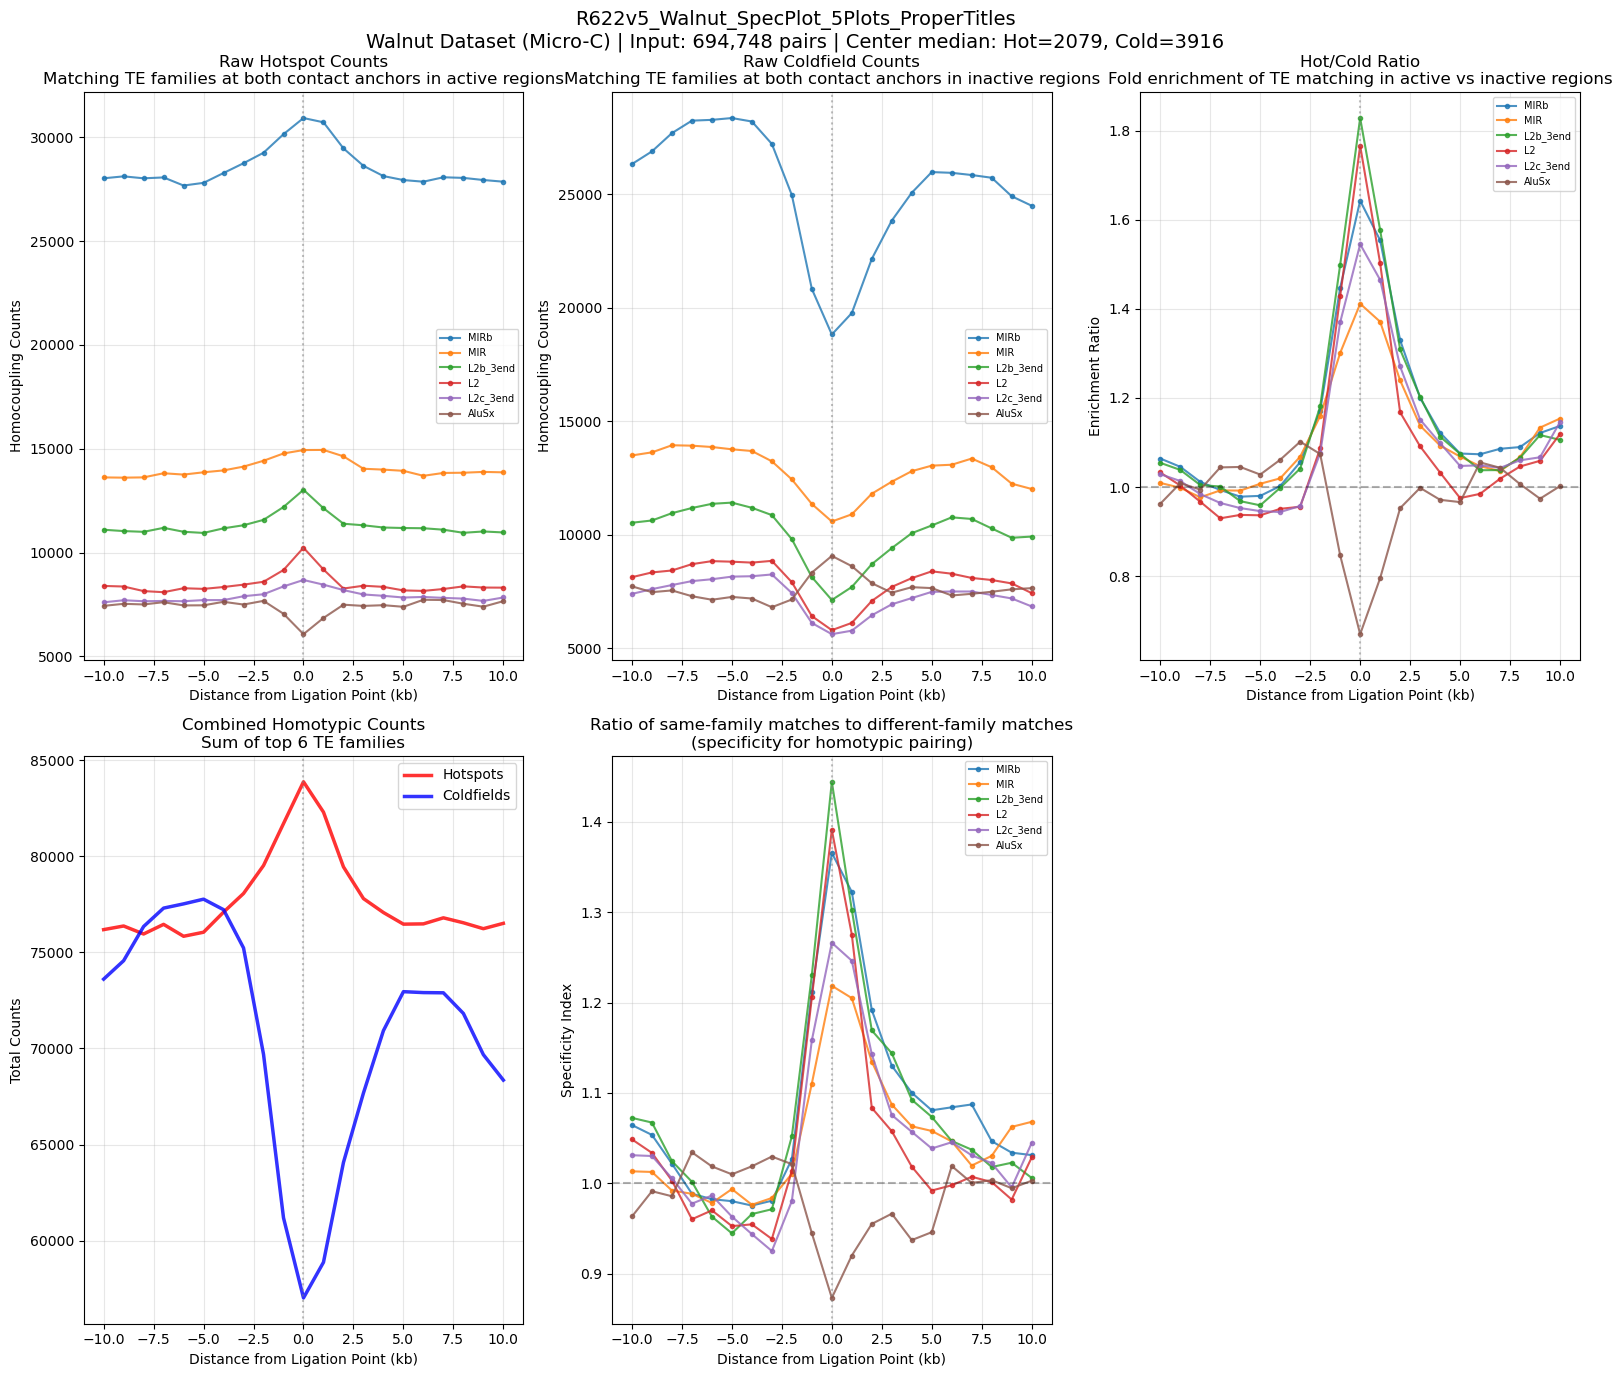


Plots saved: /home/ubuntu/00HA1py/out/te_analysis/250909_R622v5_Walnut_SpecPlot_5Plots_results/250909_R622v5_Walnut_SpecPlot_5Plots_5plots.png

2025-09-09 21:14:58 PDT Analysis complete!
  Dataset: Walnut (Micro-C)
  5 plots with proper titles
  Results saved to: /home/ubuntu/00HA1py/out/te_analysis/250909_R622v5_Walnut_SpecPlot_5Plots_results/250909_R622v5_Walnut_SpecPlot_5Plots_results.pkl

R622v5_Walnut_SpecPlot_5Plots_ProperTitles complete


In [1]:
#!/usr/bin/env python3# R622v5_Walnut_SpecPlot_5Plots_ProperTitles# Previous version: R622v4 - used Ziti dataset# cchat: current conversationscript_name = "R622v5_Walnut_SpecPlot_5Plots_ProperTitles"dataset_name = "Walnut"source_script_name = "R441v6_Hotco_Walnut_Spock_NoSkip"sff_tag = f"250909_R622v5_{dataset_name}_SpecPlot_5Plots"v_version = 5"""SEARCHABLE TAG: R622v5_Walnut_SpecPlot_5Plots_ProperTitlesNow processing Walnut dataset (Micro-C, H1-hESC likely)5 plots: separate hotspot and coldfield raw countsSliding windows with 50% overlapDataset: Walnut from R441v6"""import os, sys, pickle, timeimport numpy as npimport matplotlib.pyplot as pltfrom collections import defaultdictfrom datetime import datetime, timezone, timedeltaimport seaborn as snsfrom scipy import stats# Nice the processtry:    os.nice(10)except:    pass# ConfigurationDFAM_INDEX = "/home/ubuntu/00HA1py/tools/reference/hg38_dfam_top30_families_unfiltered_index.pkl"BIN_SIZE = 600DFAM_BIN_SIZE = 10000# Source data - WALNUT datasetSOURCE_FOLDER = "250908_(R441v6_Hotco_Walnut_Spock_NoSkip)_results"SOURCE_PATH = f"/home/ubuntu/00HA1py/out/hotco/{SOURCE_FOLDER}/paired_hotcold_all.pkl"# Create sliding windows with 50% overlapSLIDING_BINS = []# First add original binsfor i in range(11):    start = (i - 5) * 2000 - 1000    end = start + 2000    SLIDING_BINS.append((start, end, 'original'))# Add overlapping bins (offset by 1000bp)for i in range(10):    start = (i - 5) * 2000  # No -1000 offset for overlap bins    end = start + 2000    SLIDING_BINS.append((start, end, 'overlap'))# Sort by start positionSLIDING_BINS.sort(key=lambda x: x[0])N_SLIDING = len(SLIDING_BINS)print("Sliding window configuration (21 windows):")for i, (start, end, type_) in enumerate(SLIDING_BINS):    if start == -1000 and end == 1000:        print(f"  Win {i:2d}: {start:6d} to {end:6d} bp ({type_:8s}) <-- CENTER")    else:        print(f"  Win {i:2d}: {start:6d} to {end:6d} bp ({type_:8s})")# Output directorydef now_pdt():    return (datetime.now(timezone.utc) - timedelta(hours=7)).strftime("%Y-%m-%d %H:%M:%S PDT")OUT_DIR = f"/home/ubuntu/00HA1py/out/te_analysis/{sff_tag}_results"os.makedirs(OUT_DIR, exist_ok=True)# Logging setupclass TeeOutput:    def __init__(self, name, mode):        self.file = open(name, mode)        self.stdout = sys.stdout        self.stderr = sys.stderr    def write(self, data):        self.stdout.write(data)        self.file.write(data)        self.file.flush()    def flush(self):        self.stdout.flush()        self.file.flush()logfile = os.path.join(OUT_DIR, f"{script_name}.log")sys.stdout = TeeOutput(logfile, 'w')sys.stderr = sys.stdoutprint(f"{script_name} starting...")print(f"{now_pdt()} {sff_tag}")print(f"Dataset: {dataset_name} (Micro-C) from {source_script_name}")print(f"Now with 5 plots: separate hotspot and coldfield raw counts")print("="*80)def load_source_data():    """Load paired_hotcold_all.pkl from specified path"""    if not os.path.exists(SOURCE_PATH):        print(f"ERROR: File not found: {SOURCE_PATH}")        return []        print(f"Loading file: {SOURCE_PATH}")    file_size = os.path.getsize(SOURCE_PATH) / (1024**2)    print(f"  File size: {file_size:.1f} MB")        with open(SOURCE_PATH, 'rb') as f:        all_pairs = pickle.load(f)    print(f"  Loaded {len(all_pairs):,} {dataset_name} pairs")        return all_pairsdef load_dfam_index():    """Load DFAM index"""    print(f"\n{now_pdt()} Loading UNFILTERED DFAM index...")    with open(DFAM_INDEX, 'rb') as f:        dfam = pickle.load(f)    families = list(dfam['index'].keys())    print(f"  Loaded {len(families)} TE families")    return dfam, familiesdef collect_tes_sliding_windows(dfam_index, chrom, center_pos):    """Collect TEs for sliding windows"""    tes_by_window = [[] for _ in range(N_SLIDING)]        search_start = center_pos - 11000    search_end = center_pos + 11000        start_bin_idx = search_start // DFAM_BIN_SIZE    end_bin_idx = search_end // DFAM_BIN_SIZE        for family, family_index in dfam_index['index'].items():        for bin_num in range(start_bin_idx, end_bin_idx + 1):            key = (chrom, bin_num)            if key in family_index:                for elem in family_index[key]:                    te_center = (elem['start'] + elem['end']) // 2                    rel_pos = te_center - center_pos                                        # Check all sliding windows                    for win_idx, (win_start, win_end, _) in enumerate(SLIDING_BINS):                        if win_start <= rel_pos < win_end:                            tes_by_window[win_idx].append(family)        return tes_by_windowdef analyze_with_sliding_windows(dfam_index, paired_data):    """Analyze pairs using sliding windows"""        print(f"\n{now_pdt()} Processing all {len(paired_data):,} pairs...")    print("Using sliding windows for smoother curves")    print("="*80)        hot_homo_counts = defaultdict(lambda: defaultdict(int))    cold_homo_counts = defaultdict(lambda: defaultdict(int))    hot_hetero_counts = defaultdict(lambda: defaultdict(int))    cold_hetero_counts = defaultdict(lambda: defaultdict(int))        last_update = time.time()    update_interval = 5    start_time = time.time()        for idx, entry in enumerate(paired_data):                current_time = time.time()        if current_time - last_update > update_interval:            pct = 100 * idx / len(paired_data)            elapsed = current_time - start_time            rate = idx / elapsed if elapsed > 0 else 0            eta = (len(paired_data) - idx) / rate if rate > 0 else 0            print(f"{now_pdt()} Processed {idx:,}/{len(paired_data):,} ({pct:.1f}%), "                  f"Rate: {rate:.0f}/s, ETA: {eta/60:.1f} min")            last_update = current_time                        if elapsed > 100:                update_interval = 30            if elapsed > 600:                update_interval = 1200                try:            (chr_name, h_bin1, h_bin2), h_count, h_ratio, (c_bin1, c_bin2), c_max, c_ratio = entry[:6]        except:            continue                # Convert bins to genomic positions        h_pos1 = h_bin1 * BIN_SIZE + BIN_SIZE // 2        h_pos2 = h_bin2 * BIN_SIZE + BIN_SIZE // 2        c_pos1 = c_bin1 * BIN_SIZE + BIN_SIZE // 2        c_pos2 = c_bin2 * BIN_SIZE + BIN_SIZE // 2                # Get TEs for sliding windows        hot_tes_lp1 = collect_tes_sliding_windows(dfam_index, chr_name, h_pos1)        hot_tes_lp2 = collect_tes_sliding_windows(dfam_index, chr_name, h_pos2)        cold_tes_lp1 = collect_tes_sliding_windows(dfam_index, chr_name, c_pos1)        cold_tes_lp2 = collect_tes_sliding_windows(dfam_index, chr_name, c_pos2)                # Count for each sliding window        for win_idx in range(N_SLIDING):            # Hot pairs            lp1_families = set(hot_tes_lp1[win_idx])            lp2_families = set(hot_tes_lp2[win_idx])                        matched = lp1_families.intersection(lp2_families)            for fam in matched:                hot_homo_counts[win_idx][fam] += 1                        for fam1 in lp1_families:                for fam2 in lp2_families:                    if fam1 != fam2:                        hot_hetero_counts[win_idx][fam1] += 1                        # Cold pairs            lp1_families = set(cold_tes_lp1[win_idx])            lp2_families = set(cold_tes_lp2[win_idx])                        matched = lp1_families.intersection(lp2_families)            for fam in matched:                cold_homo_counts[win_idx][fam] += 1                        for fam1 in lp1_families:                for fam2 in lp2_families:                    if fam1 != fam2:                        cold_hetero_counts[win_idx][fam1] += 1        elapsed_total = time.time() - start_time    print(f"{now_pdt()} Processing complete! Total time: {elapsed_total/60:.1f} minutes")        return hot_homo_counts, cold_homo_counts, hot_hetero_counts, cold_hetero_countsdef calculate_specificity_scores(hot_homo, cold_homo, hot_hetero, cold_hetero):    """Calculate specificity for each family at each window"""        specificity_results = {}        all_families = set()    for win_idx in range(N_SLIDING):        all_families.update(hot_homo[win_idx].keys())        for family in all_families:        family_data = []                for win_idx in range(N_SLIDING):            hh = hot_homo[win_idx].get(family, 0)            ch = cold_homo[win_idx].get(family, 0)            hhet = hot_hetero[win_idx].get(family, 0)            chet = cold_hetero[win_idx].get(family, 0)                        if ch > 0:                homo_ratio = hh / ch            else:                homo_ratio = 3.0 if hh > 0 else 1.0                        if chet > 0:                hetero_ratio = hhet / chet            else:                hetero_ratio = 3.0 if hhet > 0 else 1.0                        if hetero_ratio > 0:                specificity = homo_ratio / hetero_ratio            else:                specificity = homo_ratio                        family_data.append({                'hot_homo': hh,                'cold_homo': ch,                'homo_ratio': homo_ratio,                'hetero_ratio': hetero_ratio,                'specificity': specificity            })                specificity_results[family] = family_data        return specificity_resultsdef print_summary_table(specificity_results, n_pairs):    """Print summary statistics for center window"""        # Find center window index    center_idx = -1    for i, (start, end, _) in enumerate(SLIDING_BINS):        if start == -1000 and end == 1000:            center_idx = i            break        print("\n" + "="*100)    print(f"SUMMARY TABLE: {dataset_name.upper()} - SLIDING WINDOWS")    print(f"Total input pairs: {n_pairs:,}")    print(f"CENTER WINDOW: -1 to +1 kb (window {center_idx})")    print("="*100)        center_data = []    for family, data in specificity_results.items():        hh = data[center_idx]['hot_homo']        ch = data[center_idx]['cold_homo']        if hh + ch > 0:  # Show all families            center_data.append((family, hh, ch, data[center_idx]['homo_ratio'],                               data[center_idx]['specificity']))        center_data.sort(key=lambda x: x[1], reverse=True)        print(f"{'Family':<12} {'Hot_Homo':<10} {'Cold_Homo':<10} {'H/C_Ratio':<10} {'Specificity':<12}")    print("-"*100)        for family, hh, ch, ratio, spec in center_data[:30]:        print(f"{family:<12} {hh:<10.0f} {ch:<10.0f} {ratio:<10.2f} {spec:<12.2f}")        if center_data:        total_hot = sum(x[1] for x in center_data)        total_cold = sum(x[2] for x in center_data)                print("-"*100)        print(f"{'TOTAL':<12} {total_hot:<10.0f} {total_cold:<10.0f} {total_hot/total_cold if total_cold > 0 else 0:<10.2f}")        print("="*100)        return center_data, center_idxdef plot_sliding_window_results(specificity_results, n_pairs, center_data, center_idx):    """Create 5 plots with proper descriptive titles"""        # Get top families by total counts    family_totals = []    for family, data in specificity_results.items():        total = sum(data[i]['hot_homo'] + data[i]['cold_homo'] for i in range(N_SLIDING))        family_totals.append((family, total))        family_totals.sort(key=lambda x: x[1], reverse=True)    top_families = [f for f, _ in family_totals[:6]]  # Always plot top 6        # Calculate median pairs in center    if center_data:        median_hot = np.median([x[1] for x in center_data])        median_cold = np.median([x[2] for x in center_data])    else:        median_hot = median_cold = 0        # Create figure with 5 subplots    fig = plt.figure(figsize=(16, 14))        # Calculate distances    distances = []    for start, end, _ in SLIDING_BINS:        center_pos = (start + end) / 2000  # Convert to kb        distances.append(center_pos)        # Plot 1: Raw hotspot counts    ax1 = plt.subplot(2, 3, 1)    for family in top_families:        hot_counts = [specificity_results[family][i]['hot_homo'] for i in range(N_SLIDING)]        ax1.plot(distances, hot_counts, marker='o', label=family, linewidth=1.5, markersize=3, alpha=0.8)        ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)    ax1.set_xlabel('Distance from Ligation Point (kb)')    ax1.set_ylabel('Homocoupling Counts')    ax1.set_title('Raw Hotspot Counts\nMatching TE families at both contact anchors in active regions')    ax1.legend(fontsize=7)    ax1.grid(True, alpha=0.3)        # Plot 2: Raw coldfield counts    ax2 = plt.subplot(2, 3, 2)    for family in top_families:        cold_counts = [specificity_results[family][i]['cold_homo'] for i in range(N_SLIDING)]        ax2.plot(distances, cold_counts, marker='o', label=family, linewidth=1.5, markersize=3, alpha=0.8)        ax2.axvline(x=0, color='gray', linestyle=':', alpha=0.5)    ax2.set_xlabel('Distance from Ligation Point (kb)')    ax2.set_ylabel('Homocoupling Counts')    ax2.set_title('Raw Coldfield Counts\nMatching TE families at both contact anchors in inactive regions')    ax2.legend(fontsize=7)    ax2.grid(True, alpha=0.3)        # Plot 3: Hot/Cold ratio    ax3 = plt.subplot(2, 3, 3)    for family in top_families:        ratios = [specificity_results[family][i]['homo_ratio'] for i in range(N_SLIDING)]        ax3.plot(distances, ratios, marker='o', label=family, linewidth=1.5, markersize=3, alpha=0.8)        ax3.axvline(x=0, color='gray', linestyle=':', alpha=0.5)    ax3.axhline(y=1.0, color='black', linestyle='--', alpha=0.3)    ax3.set_xlabel('Distance from Ligation Point (kb)')    ax3.set_ylabel('Enrichment Ratio')    ax3.set_title('Hot/Cold Ratio\nFold enrichment of TE matching in active vs inactive regions')    ax3.legend(fontsize=7)    ax3.grid(True, alpha=0.3)        # Plot 4: Combined homotypic counts    ax4 = plt.subplot(2, 3, 4)    hot_totals = [sum(specificity_results[f][i]['hot_homo'] for f in top_families) for i in range(N_SLIDING)]    cold_totals = [sum(specificity_results[f][i]['cold_homo'] for f in top_families) for i in range(N_SLIDING)]        ax4.plot(distances, hot_totals, 'r-', label='Hotspots', linewidth=2.5, alpha=0.8)    ax4.plot(distances, cold_totals, 'b-', label='Coldfields', linewidth=2.5, alpha=0.8)    ax4.axvline(x=0, color='gray', linestyle=':', alpha=0.5)    ax4.set_xlabel('Distance from Ligation Point (kb)')    ax4.set_ylabel('Total Counts')    ax4.set_title('Combined Homotypic Counts\nSum of top 6 TE families')    ax4.legend()    ax4.grid(True, alpha=0.3)        # Plot 5: Specificity (homo vs hetero)    ax5 = plt.subplot(2, 3, 5)    for family in top_families:        specs = [specificity_results[family][i]['specificity'] for i in range(N_SLIDING)]        ax5.plot(distances, specs, marker='o', label=family, linewidth=1.5, markersize=3, alpha=0.8)        ax5.axvline(x=0, color='gray', linestyle=':', alpha=0.5)    ax5.axhline(y=1.0, color='black', linestyle='--', alpha=0.3)    ax5.set_xlabel('Distance from Ligation Point (kb)')    ax5.set_ylabel('Specificity Index')    ax5.set_title('Ratio of same-family matches to different-family matches\n(specificity for homotypic pairing)')    ax5.legend(fontsize=7)    ax5.grid(True, alpha=0.3)        plt.suptitle(f'{script_name}\n{dataset_name} Dataset (Micro-C) | Input: {n_pairs:,} pairs | Center median: Hot={median_hot:.0f}, Cold={median_cold:.0f}',                  fontsize=14)    plt.tight_layout()        plot_path = os.path.join(OUT_DIR, f'{sff_tag}_5plots.png')    plt.savefig(plot_path, dpi=150, bbox_inches='tight')    plt.show()        print(f"\nPlots saved: {plot_path}")def main():    print(f"\n{now_pdt()} Loading {dataset_name} dataset...")    paired_data = load_source_data()        if not paired_data:        print(f"ERROR: No data loaded")        return        n_pairs = len(paired_data)        dfam_index, all_families = load_dfam_index()        # Analyze with sliding windows    hot_homo, cold_homo, hot_hetero, cold_hetero = analyze_with_sliding_windows(dfam_index, paired_data)        print(f"\n{now_pdt()} Calculating specificity scores...")    specificity_results = calculate_specificity_scores(hot_homo, cold_homo, hot_hetero, cold_hetero)        # Print results and get center data    center_data, center_idx = print_summary_table(specificity_results, n_pairs)        # Generate plots (always, regardless of counts)    plot_sliding_window_results(specificity_results, n_pairs, center_data, center_idx)        # Save results    results_file = os.path.join(OUT_DIR, f'{sff_tag}_results.pkl')    with open(results_file, 'wb') as f:        pickle.dump({            'hot_homo_counts': dict(hot_homo),            'cold_homo_counts': dict(cold_homo),            'hot_hetero_counts': dict(hot_hetero),            'cold_hetero_counts': dict(cold_hetero),            'specificity_results': specificity_results,            'n_pairs': n_pairs,            'dataset': dataset_name,            'sliding_windows': SLIDING_BINS,            'center_data': center_data        }, f)        print(f"\n{now_pdt()} Analysis complete!")    print(f"  Dataset: {dataset_name} (Micro-C)")    print(f"  5 plots with proper titles")    print(f"  Results saved to: {results_file}")if __name__ == "__main__":    try:        main()    except KeyboardInterrupt:        print(f"\n{now_pdt()} Processing interrupted")    except Exception as e:        print(f"\n{now_pdt()} Error: {e}")        import traceback        traceback.print_exc()print(f"\n{script_name} complete")#chm3